### Download Flowers dataset

In [ ]:
#You can download the data manually as well instead of using 'wget'
!wget http://download.tensorflow.org/example_images/flower_photos.tgz --quiet

In [ ]:
!tar -xf flower_photos.tgz

In [ ]:
!ls -l

total 223464
drwxr-x--- 7 270850 5000      4096 Feb 10  2016 flower_photos
-rw-r--r-- 1 root   root 228813984 Feb 10  2016 flower_photos.tgz
drwxr-xr-x 1 root   root      4096 Jun 18 13:23 sample_data


In [1]:
!ls -l flower_photos

total 824
-rw-r-----    1 joanna  staff  418049 Feb  9  2016 LICENSE.txt
drwx------  635 joanna  staff   20320 Feb 11  2016 daisy
drwx------  900 joanna  staff   28800 Feb 11  2016 dandelion
drwx------  643 joanna  staff   20576 Feb 11  2016 roses
drwx------  701 joanna  staff   22432 Feb 11  2016 sunflowers
drwx------  801 joanna  staff   25632 Feb 11  2016 tulips


In [2]:
#We will build a pandas dataset
import pandas as pd
df = pd.DataFrame(columns=['class','image_file'])

In [4]:
#Read the dataset
import tarfile
dataset = tarfile.open('flower_photos.tgz')

In [6]:
dataset.getnames()[3]

'flower_photos/roses/1446090416_f0cad5fde4.jpg'

In [7]:
len(dataset.getnames())

3677

In [8]:
#Run through tarfile members
for name in dataset.getnames():

    tar_mem = dataset.getmember(name)

    #Check if it is a file
    if(tar_mem.isfile() and name.endswith('.jpg')):
        #Build directory and class info
        im_dir = name[0:name.rfind('/')]
        im_class = im_dir[im_dir.rfind('/')+1:]
        #Add record to the dataframe
        df.loc[df.shape[0]] = [im_class, name]

In [9]:
df.sample(n=10)

,class,image_file
187,roses,flower_photos/roses/14221192676_eb8c89a7d6_n.jpg
1118,sunflowers,flower_photos/sunflowers/10386540696_0a95ee53a...
1619,tulips,flower_photos/tulips/8713398906_28e59a225a_n.jpg
968,sunflowers,flower_photos/sunflowers/4989952542_35f2cdd5e2...
1280,sunflowers,flower_photos/sunflowers/4932736308_827012cff2...
812,sunflowers,flower_photos/sunflowers/7270375648_79f0caef42...
3115,dandelion,flower_photos/dandelion/1241011700_261ae180ca.jpg
2932,dandelion,flower_photos/dandelion/7141019507_4a44c6e888_...
13,roses,flower_photos/roses/6039330368_c30ed224c4_m.jpg
575,roses,flower_photos/roses/16374919860_4e445de29f_n.jpg


Create Training & Test Dataset

In [10]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
train_df.to_csv('flower_photos/train.csv',index=False)
test_df.to_csv('flower_photos/test.csv', index=False)

### Read training and test data

In [12]:
#Read training and test Dataframe
train_df = pd.read_csv('flower_photos/train.csv')
test_df = pd.read_csv('flower_photos/test.csv')

In [13]:
train_df.shape

(2936, 2)

In [14]:
test_df.shape

(734, 2)

In [15]:
#Check contents
train_df.sample(n=5)

,class,image_file
1478,sunflowers,flower_photos/sunflowers/19359539074_d7e32e661...
621,daisy,flower_photos/daisy/9922116524_ab4a2533fe_n.jpg
2416,tulips,flower_photos/tulips/7166570828_7c26ca5766_n.jpg
2356,tulips,flower_photos/tulips/7481215720_73e40f178f_n.jpg
2920,dandelion,flower_photos/dandelion/17122969189_0ec37cb6c9...


In [16]:
#Get class names
class_names = train_df['class'].unique().tolist()
print('Flower classes: ', class_names)

Flower classes:  ['tulips', 'daisy', 'sunflowers', 'dandelion', 'roses']


### Build Batch generator (using ImageDataGenerator)

In [17]:
import tensorflow as tf
import numpy as np

2024-06-23 17:30:21.852642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
#Define some parameters
img_size = 224
img_depth = 3

Function to normalize image according to Model being used

In [19]:
def normalize_data(img):

    #Normalize for ResNet50
    return tf.keras.applications.resnet50.preprocess_input(img)

Defime ImageDataGenerator for both Training and Test Separately

In [20]:
#Define Training Data Generator with augmentations
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                preprocessing_function=normalize_data) #Normalize the data accordingly

In [21]:
#Define Test Data Generator with NO augmentations
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=normalize_data) #Normalize the data accordingly

Create Data Generators objects for Training and Test

In [22]:
train_df.head()

,class,image_file
0,tulips,flower_photos/tulips/3502685880_f026400dce_n.jpg
1,daisy,flower_photos/daisy/16025261368_911703a536_n.jpg
2,sunflowers,flower_photos/sunflowers/5970869550_d7d9fabebd...
3,dandelion,flower_photos/dandelion/8223949_2928d3f6f6_n.jpg
4,roses,flower_photos/roses/15277801151_5ed88f40f0_n.jpg


In [23]:
#Training (from dataframe)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='image_file', #File path for image
                                                    y_col='class',           #Class for the image
                                                    target_size=(img_size, img_size), #Image resize dimensions
                                                    batch_size=64)

Found 2936 validated image filenames belonging to 5 classes.


In [24]:
#Test (from dataframe)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='image_file', #File path for image
                                                  y_col='class',           #Class for the image
                                                  target_size=(img_size, img_size), #Image resize dimensions
                                                  batch_size=64)

Found 734 validated image filenames belonging to 5 classes.


ImageDataGenerator has lot of useful features. Learn more about ImageDataGenerator at https://keras.io/preprocessing/image/

In [25]:
x, y =  next(train_generator)

In [26]:
x.shape

(64, 224, 224, 3)

In [ ]:
#x[0]

In [27]:
y.shape

(64, 5)

### Load pre-trained model

In [28]:
tf.keras.backend.clear_session()
model = tf.keras.applications.ResNet50(include_top=False,
                                       weights='imagenet',
                                       input_shape=(img_size,img_size, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 46s 0us/step


In [29]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [30]:
model.output

<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_174>

Freeze the layers in Pre-trained model

In [31]:
#model.layers

In [32]:
len(model.layers)

175

In [33]:
#Set pre-trained model layers to not trainable
for layer in model.layers:
    layer.trainable = False

In [34]:
#Check if layers frozen
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Add FC layer for new classes

In [35]:
model.output

<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_174>

In [36]:
#get Output layer of Pre0trained model
x1 = model.output

#Global average pool to reduce number of features and Flatten the output
x2 = tf.keras.layers.GlobalAveragePooling2D()(x1)

In [37]:
#Output shape of Global Average Pooling
x2

<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_175>

In [38]:
#Add output layer
prediction = tf.keras.layers.Dense(len(class_names),activation='softmax')(x2)

In [ ]:
prediction

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>

### Building final model for Classification

In [39]:
#Using Keras Model class
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

In [40]:
#Compile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
#How does our overall model looks
final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Train the model

In [43]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('flowers_resnet.keras',
                                                    save_best_only=True,
                                                    monitor='val_accuracy',
                                                    mode='max',
                                                    verbose=1)

In [ ]:
final_model.fit(train_generator,
                epochs=5,
                steps_per_epoch= 2936//64,
                validation_data=test_generator,
                validation_steps = 734//64,
                callbacks=[model_checkpoint])

Epoch 1/5


In [ ]:
final_model.fit(train_generator,
                epochs=10,
                initial_epoch=5,
                steps_per_epoch= 2936//64,
                validation_data=test_generator,
                validation_steps = 734//64,
                callbacks=[model_checkpoint])

Epoch 6/10
45/45 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9217
Epoch 6: val_accuracy did not improve from 0.90483
45/45 [==============================] - 46s 1s/step - loss: 0.2233 - accuracy: 0.9217 - val_loss: 0.2778 - val_accuracy: 0.9034
Epoch 7/10
45/45 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9335
Epoch 7: val_accuracy improved from 0.90483 to 0.90767, saving model to flowers_resnet.h5
45/45 [==============================] - 44s 982ms/step - loss: 0.2013 - accuracy: 0.9335 - val_loss: 0.2609 - val_accuracy: 0.9077
Epoch 8/10
45/45 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9373
Epoch 8: val_accuracy improved from 0.90767 to 0.91477, saving model to flowers_resnet.h5
45/45 [==============================] - 44s 990ms/step - loss: 0.1899 - accuracy: 0.9373 - val_loss: 0.2579 - val_accuracy: 0.9148
Epoch 9/10
45/45 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9380


In [ ]:
#Lets train for 5 more steps
final_model.fit(train_generator,
                epochs=15,
                initial_epoch=10,
                steps_per_epoch= 2936//64,
                validation_data=test_generator,
                validation_steps = 734//64,
                callbacks=[model_checkpoint])

### Unfreeze some of Trained Layers in ResNet

In [ ]:
print(len(model.layers))

175


Let's unfreeze some layers at the end (which have high end features more specific to ImageNet)

In [ ]:
#Unfreezing all layers after layer#
for layer in model.layers[170:]:
    layer.trainable = True

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
#We will need to recompile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
#Lets train for 10 steps
final_model.fit(train_generator,
                epochs=30,
                initial_epoch=15,
                steps_per_epoch= 2936//64,
                validation_data=test_generator,
                validation_steps = 734//64,
                callbacks=[model_checkpoint])

Epoch 16/30
45/45 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.9130
Epoch 16: val_accuracy did not improve from 0.92330
45/45 [==============================] - 49s 986ms/step - loss: 0.2687 - accuracy: 0.9130 - val_loss: 0.4508 - val_accuracy: 0.8793
Epoch 17/30
45/45 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9540
Epoch 17: val_accuracy did not improve from 0.92330
45/45 [==============================] - 45s 984ms/step - loss: 0.1244 - accuracy: 0.9540 - val_loss: 0.3514 - val_accuracy: 0.9105
Epoch 18/30
45/45 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9711
Epoch 18: val_accuracy did not improve from 0.92330
45/45 [==============================] - 44s 985ms/step - loss: 0.0891 - accuracy: 0.9711 - val_loss: 0.3841 - val_accuracy: 0.8935
Epoch 19/30
45/45 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9805
Epoch 19: val_accuracy improved from 0.92330 to 0.93324, saving mode

In [ ]:
#Lets train for 10 steps
final_model.fit(train_generator,
                epochs=45,
                initial_epoch=30,
                steps_per_epoch= 2936//64,
                validation_data=test_generator,
                validation_steps = 734//64,
                callbacks=[model_checkpoint])

Epoch 31/45
45/45 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9958
Epoch 31: val_accuracy did not improve from 0.93324
45/45 [==============================] - 44s 979ms/step - loss: 0.0186 - accuracy: 0.9958 - val_loss: 0.3255 - val_accuracy: 0.9233
Epoch 32/45
45/45 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9955
Epoch 32: val_accuracy did not improve from 0.93324
45/45 [==============================] - 44s 979ms/step - loss: 0.0202 - accuracy: 0.9955 - val_loss: 0.4967 - val_accuracy: 0.8906
Epoch 33/45
45/45 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9958
Epoch 33: val_accuracy did not improve from 0.93324
45/45 [==============================] - 44s 976ms/step - loss: 0.0163 - accuracy: 0.9958 - val_loss: 0.2545 - val_accuracy: 0.9318
Epoch 34/45
45/45 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9965
Epoch 34: val_accuracy did not improve from 0.93324
45/45 [=========

KeyboardInterrupt: 

In [ ]:
#Unfreezing all layers after layer#
for layer in model.layers[140:]:
    layer.trainable = True

In [ ]:
adam_opt = tf.keras.optimizers.Adam(lr=0.00001)
final_model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
final_model.summary()

In [ ]:
#Lets train for 10 steps
final_model.fit(train_generator,
                epochs=20,
                initial_epoch=15,
                steps_per_epoch= 2936//64,
                validation_data=test_generator,
                validation_steps = 734//64,
                callbacks=[model_checkpoint])

In [ ]:
#Lets train for 10 steps
final_model.fit(train_generator,
                epochs=40,
                initial_epoch=25,
                steps_per_epoch= 2936//64,
                validation_data=test_generator,
                validation_steps = 734//64,
                callbacks=[model_checkpoint])

In [ ]:
final_model.save('flowers.h5')

In [ ]:
!ls -l

#### Model Prediction

In [ ]:
#!ls -l flower_photos/daisy

In [ ]:
test_df.head()

,class,image_file
0,roses,flower_photos/roses/4754734410_94d98463a5.jpg
1,daisy,flower_photos/daisy/5693459303_e61d9a9533.jpg
2,dandelion,flower_photos/dandelion/20165867412_fc45d31698...
3,sunflowers,flower_photos/sunflowers/14901528533_ac1ce0906...
4,sunflowers,flower_photos/sunflowers/13095941995_9a66faa71...


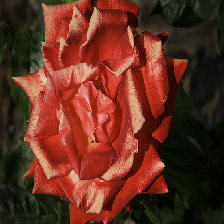

In [ ]:
#Load an image
img = tf.keras.preprocessing.image.load_img('flower_photos/roses/4754734410_94d98463a5.jpg',
                                            target_size=(img_size, img_size))
img

In [ ]:
#Convert to numpy array
img_array = tf.keras.preprocessing.image.img_to_array(img)

#Normalize array
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

In [ ]:
img_array.shape

(224, 224, 3)

In [ ]:
#Make it a batch
img_array = tf.expand_dims(img_array, axis=0)

In [ ]:
img_array.shape

TensorShape([1, 224, 224, 3])

In [ ]:
#Predict
preds = final_model.predict(img_array)

#Print prediction
preds

1/1 [==============================] - 1s 1s/step


array([[6.0145567e-07, 2.2468240e-07, 9.9982882e-01, 3.6768861e-06,
        1.6662612e-04]], dtype=float32)

In [ ]:
#Class index with highest probability
tf.argmax(preds[0]).numpy()

2

In [ ]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

#### Residual block

In [ ]:
#Input to residual block
x = tf.keras.layers.Input(shape=(28,28,64,))

#First convolution layer
c1 = tf.keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu', padding='same')(x)

#Second convolution layer
c2 = tf.keras.layers.Conv2D(64,kernel_size=(3,3), padding='same')(c1)

#Add operation
a1 = tf.keras.layers.Add()([c2,x])
r1 = tf.keras.layers.ReLU()(a1)

In [ ]:
x

<KerasTensor: shape=(None, 28, 28, 64) dtype=float32 (created by layer 'input_4')>

In [ ]:
c1

<KerasTensor: shape=(None, 28, 28, 64) dtype=float32 (created by layer 'conv2d_4')>

In [ ]:
c2

<KerasTensor: shape=(None, 28, 28, 64) dtype=float32 (created by layer 'conv2d_5')>

In [ ]:
a1

<KerasTensor: shape=(None, 28, 28, 64) dtype=float32 (created by layer 'add_2')>

In [ ]:
r1

<KerasTensor: shape=(None, 28, 28, 64) dtype=float32 (created by layer 're_lu')>

In [ ]:
res_model = tf.keras.models.Model(x, r1)

In [ ]:
res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 64)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 28, 64)   36928       ['input_4[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 64)   36928       ['conv2d_4[0][0]']               
                                                                                                  
 add_2 (Add)                    (None, 28, 28, 64)   0           ['conv2d_5[0][0]',         

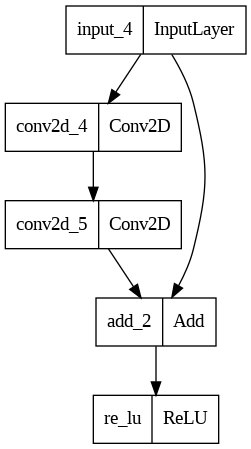

In [ ]:
tf.keras.utils.plot_model(res_model)